<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Suicide_Ideation/blob/master/USE_BERT_500_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict
np.seterr(divide = 'ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
from google.colab import files
files.upload()

In [3]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)
     |████████████████████████████████| 215.7MB 72kB/s 
     |████████████████████████████████| 204kB 50.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130389 sha256=ebc52358d1b701151fc258e193a52cd565d0f85e29a10881ac46280fb706f886
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
     |████████████████████████████████| 143kB 8.4MB/s 


In [4]:
import sparknlp

spark = sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version", spark.version)

Spark NLP version:  2.7.1
Apache Spark version 2.4.4


In [5]:
data = pd.read_csv('/content/500_Reddit_users_posts_labels.csv', index_col = 'User')
data.head(5)

,Post,Label
User,,
user-0,"['Its not a viable option, and youll be leavin...",Supportive
user-1,['It can be hard to appreciate the notion that...,Ideation
user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
user-3,['I tried to kill my self once and failed badl...,Attempt
user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


In [6]:
data.shape

(500, 2)

In [7]:
data['Label'].value_counts()

Ideation      171
Supportive    108
Indicator      99
Behavior       77
Attempt        45
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


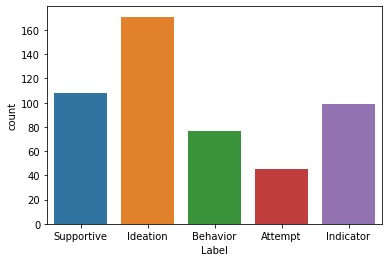

In [8]:
import seaborn as sns
sns.countplot(data['Label'])

In [9]:
data['Post'][0]

"['Its not a viable option, and youll be leaving your wife behind. Youd Pain her beyond comprehension.It sucks worrying about money, I know that first hand. It can definitely feel hopeless, as you seem to be Tired aware of. Your wife might need to chip in financially. I know time is an issue, but even 10-15 hours a Asthenia could alleviate a lot of the pressure. In the meantime, get your shit together - write that resume tomorrow. No excuses, get it done and send it out. Whether you believe in some sort of powerful being or force governing things or not, things really do work themselves out. This is a big test for you, and youll pull through. Just try to stay as positive as you can and everything will work out.']"

In [10]:
spark_df = spark.read.option("header", "true").option("multiLine", "true").option("quote", "\"").option("escape", "\"").option("inferSchema", "true").csv('/content/500_Reddit_users_posts_labels.csv', sep = ',')

In [12]:
display(spark_df)

DataFrame[User: string, Post: string, Label: string]

In [14]:
spark_df.printSchema()

root
 |-- User: string (nullable = true)
 |-- Post: string (nullable = true)
 |-- Label: string (nullable = true)



In [17]:

spark_split_df = spark_df

(train_data, test_data) = spark_split_df.randomSplit([0.9, 0.1], 24)

print("Train length", train_data.count())
print("Test length", test_data.count())

Train length 456
Test length 44


In [18]:
from pyspark.ml import Pipeline

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [21]:
document = DocumentAssembler()\
    .setInputCol("Post")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained() \
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
sentimentdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("Label")\
  .setMaxEpochs(20)\
  .setEnableOutputLogs(True)

pipeline = Pipeline(
    stages = [
        document,
        use,
        sentimentdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [22]:
pipelineModel = pipeline.fit(train_data)

In [23]:
!cd ~/annotator_logs && ls -l

total 4
-rw-r--r-- 1 root root 1458 Jan 11 12:39 ClassifierDLApproach_273e67d66b3d.log


In [24]:
!cat ~/annotator_logs/ClassifierDLApproach_273e67d66b3d.log

Training started - epochs: 20 - learning_rate: 0.005 - batch_size: 64 - training_examples: 456 - classes: 5
Epoch 0/20 - 0.54s - loss: 14.380881 - acc: 0.3482143 - batches: 8
Epoch 1/20 - 0.13s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 2/20 - 0.13s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 3/20 - 0.14s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 4/20 - 0.13s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 5/20 - 0.12s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 6/20 - 0.13s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 7/20 - 0.20s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 8/20 - 0.18s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 9/20 - 0.14s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 10/20 - 0.13s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 11/20 - 0.13s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 12/20 - 0.13s - loss: 14.238661 - acc: 0.3705357 - batches: 8
Epoch 13/20 - 0.13

In [25]:
document = DocumentAssembler()\
    .setInputCol("Post")\
    .setOutputCol("document")
    
# we can also use sentence detector here 
# if we want to train on and get predictions for each sentence
# downloading pretrained embeddings
bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")
# the classes/labels/categories are in category column

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("Label")\
  .setMaxEpochs(20)\
  .setEnableOutputLogs(True)

bert_sent_clf_pipeline = Pipeline(
    stages = [
        document,
        bert_sent,
        classsifierdl
    ])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [26]:
bert_pipelineModel = bert_sent_clf_pipeline.fit(train_data)

In [27]:
!cd ~/annotator_logs && ls -l

total 8
-rw-r--r-- 1 root root 1458 Jan 11 12:39 ClassifierDLApproach_273e67d66b3d.log
-rw-r--r-- 1 root root 1475 Jan 11 12:43 ClassifierDLApproach_bdfa3f74cedd.log


In [28]:
!cat ~/annotator_logs/ClassifierDLApproach_bdfa3f74cedd.log

Training started - epochs: 20 - learning_rate: 0.005 - batch_size: 64 - training_examples: 456 - classes: 5
Epoch 0/20 - 0.54s - loss: 11.955034 - acc: 0.24107143 - batches: 8
Epoch 1/20 - 0.13s - loss: 12.238629 - acc: 0.22767857 - batches: 8
Epoch 2/20 - 0.13s - loss: 12.238647 - acc: 0.22767857 - batches: 8
Epoch 3/20 - 0.13s - loss: 12.238642 - acc: 0.22767857 - batches: 8
Epoch 4/20 - 0.13s - loss: 12.238632 - acc: 0.22767857 - batches: 8
Epoch 5/20 - 0.13s - loss: 12.238615 - acc: 0.22767857 - batches: 8
Epoch 6/20 - 0.13s - loss: 12.238569 - acc: 0.22767857 - batches: 8
Epoch 7/20 - 0.13s - loss: 12.238449 - acc: 0.22767857 - batches: 8
Epoch 8/20 - 0.16s - loss: 12.238008 - acc: 0.22767857 - batches: 8
Epoch 9/20 - 0.12s - loss: 12.237078 - acc: 0.22767857 - batches: 8
Epoch 10/20 - 0.13s - loss: 12.570199 - acc: 0.20535715 - batches: 8
Epoch 11/20 - 0.13s - loss: 12.03069 - acc: 0.26339287 - batches: 8
Epoch 12/20 - 0.13s - loss: 12.193668 - acc: 0.22767857 - batches: 8
Epoch 

In [29]:
document_assembler = DocumentAssembler().setInputCol("Post").setOutputCol("document")

tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner().setInputCols(["normalized"]).setOutputCol("cleanTokens").setCaseSensitive(False)
    
lemma = LemmatizerModel.pretrained('lemma_antbnc')\
    .setInputCols(["cleanTokens"])\
    .setOutputCol("lemma")
# we can also use sentence detector here 
# if we want to train on and get predictions for each sentence
# downloading pretrained embeddings
word_embeddings = WordEmbeddingsModel.pretrained()\
 .setInputCols(["document", "lemma"])\
 .setOutputCol("embeddings")\
 .setCaseSensitive(False)
embeddings_sentence = SentenceEmbeddings().setInputCols(["document","embeddings"]).setOutputCol("sentence_embeddings").setPoolingStrategy("AVERAGE")

# the classes/labels/categories are in category column

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("Label")\
  .setMaxEpochs(20)\
  .setEnableOutputLogs(True)

clf_pipeline = Pipeline(
    stages = [
        document_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner,
        lemma,
        word_embeddings,
        embeddings_sentence,
        classsifierdl
    ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [30]:
clf_pipelineModel = clf_pipeline.fit(train_data)

In [31]:
!cd ~/annotator_logs && ls -l

total 12
-rw-r--r-- 1 root root 1458 Jan 11 12:39 ClassifierDLApproach_273e67d66b3d.log
-rw-r--r-- 1 root root 1459 Jan 11 12:45 ClassifierDLApproach_51bf82349f04.log
-rw-r--r-- 1 root root 1475 Jan 11 12:43 ClassifierDLApproach_bdfa3f74cedd.log


In [32]:
!cat ~/annotator_logs/ClassifierDLApproach_51bf82349f04.log

Training started - epochs: 20 - learning_rate: 0.005 - batch_size: 64 - training_examples: 456 - classes: 5
Epoch 0/20 - 0.54s - loss: 13.480497 - acc: 0.35044643 - batches: 8
Epoch 1/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 2/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 3/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 4/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 5/20 - 0.16s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 6/20 - 0.14s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 7/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 8/20 - 0.14s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 9/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 10/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 11/20 - 0.14s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 12/20 - 0.13s - loss: 13.238661 - acc: 0.3549107 - batches: 8
Epoch 13/20 - 0.1